##### Copyright 2020 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Copyright 2020 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/hub/tutorials/boundless"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看 </a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/hub/tutorials/boundless.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/hub/tutorials/boundless.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">查看上GitHub</a></td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/hub/tutorials/boundless.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a> </td>
  <td><a href="https://tfhub.dev/s?q=google%2Fboundless"><img src="https://tensorflow.google.cn/images/hub_logo_32px.png">查看 TF Hub 模型</a></td>
</table>

# 无限 Colab

欢迎使用无限模型 Colab！此笔记本将指导您完成在图像上运行模型并可视化结果的各个步骤。

## 概述

无限模型是一种用于图像外推的模型。这种模型会接受图像，并在内部遮盖图像的一部分（[1/2](https://tfhub.dev/google/boundless/half/1)、[1/4](https://tfhub.dev/google/boundless/quarter/1)、[3/4](https://tfhub.dev/google/boundless/three_quarter/1)），随后补足遮盖的部分。有关更多详细信息，请参阅 [Boundless: Generative Adversarial Networks for Image Extension](https://arxiv.org/pdf/1908.07007.pdf) 或 TensorFlow Hub 上的模型文档。

## 导入和设置

让我们从基础导入开始。

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from io import BytesIO
from PIL import Image as PilImage
import numpy as np
from matplotlib import pyplot as plt
from six.moves.urllib.request import urlopen

2022-12-14 22:27:05.300381: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:27:05.300484: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:27:05.300495: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## 读取图像作为输入

让我们创建一个实用方法来帮助加载图像并针对模型 (257x257x3) 格式化图像。此方法还会将图像裁切成正方形以避免畸变，您可以将此方法用于本地图像或网络图像。

In [3]:
  def read_image(filename):
    fd = None
    if(filename.startswith('http')):
      fd = urlopen(filename)
    else:
      fd = tf.io.gfile.GFile(filename, 'rb')

    pil_image = PilImage.open(fd)
    width, height = pil_image.size
    # crop to make the image square
    pil_image = pil_image.crop((0, 0, height, height))
    pil_image = pil_image.resize((257,257),PilImage.ANTIALIAS)
    image_unscaled = np.array(pil_image)
    image_np = np.expand_dims(
        image_unscaled.astype(np.float32) / 255., axis=0)
    return image_np

## 可视化方法

我们还将创建一个可视化方法来并排显示原始图像，以及由模型生成的遮盖版本和“填充”版本图像。

In [4]:
def visualize_output_comparison(img_original, img_masked, img_filled):
  plt.figure(figsize=(24,12))
  plt.subplot(131)
  plt.imshow((np.squeeze(img_original)))
  plt.title("Original", fontsize=24)
  plt.axis('off')
  plt.subplot(132)
  plt.imshow((np.squeeze(img_masked)))
  plt.title("Masked", fontsize=24)
  plt.axis('off')
  plt.subplot(133)
  plt.imshow((np.squeeze(img_filled)))
  plt.title("Generated", fontsize=24)
  plt.axis('off')
  plt.show()

## 加载图像

我们将加载示例图像，但您也可以随意将自己的图像上传到 Colab 并进行尝试。请记住，模型对包含人的图像具有一些限制。

In [5]:
wikimedia = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/Nusfjord_road%2C_2010_09.jpg/800px-Nusfjord_road%2C_2010_09.jpg"
# wikimedia = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Beech_forest_M%C3%A1tra_in_winter.jpg/640px-Beech_forest_M%C3%A1tra_in_winter.jpg"
# wikimedia = "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Marmolada_Sunset.jpg/640px-Marmolada_Sunset.jpg"
# wikimedia = "https://upload.wikimedia.org/wikipedia/commons/thumb/9/9d/Aegina_sunset.jpg/640px-Aegina_sunset.jpg"

input_img = read_image(wikimedia)

/tmpfs/tmp/ipykernel_100172/3295904410.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  pil_image = pil_image.resize((257,257),PilImage.ANTIALIAS)


## 从 TensorFlow Hub 选择模型

TensorFlow Hub 上提供了 3 种版本的无限模型：Half（一半）、Quarter（四分之一）和 Three Quarters（四分之三）。在下面的单元中，您可以选择其中任一版本，然后尝试使用您的图像运行模型。如果您想尝试另一版本，只需选择版本并执行以下单元。

In [6]:
#@title Model Selection { display-mode: "form" }
model_name = 'Boundless Quarter' # @param ['Boundless Half', 'Boundless Quarter', 'Boundless Three Quarters']
model_handle_map = {
    'Boundless Half' : 'https://tfhub.dev/google/boundless/half/1',
    'Boundless Quarter' : 'https://tfhub.dev/google/boundless/quarter/1', 
    'Boundless Three Quarters' : 'https://tfhub.dev/google/boundless/three_quarter/1'
}

model_handle = model_handle_map[model_name]


现在，我们已经选择了所需的模型，让我们从 TensorFlow Hub 加载该模型。

**注**：您可以将浏览器指向模型句柄以阅读模型的文档。

In [7]:
print("Loading model {} ({})".format(model_name, model_handle))
model = hub.load(model_handle)

Loading model Boundless Quarter (https://tfhub.dev/google/boundless/quarter/1)


## 进行推断

无限模型有两个输出：

- 对输入图像应用遮盖，输出遮盖图像
- 采用外推算法对遮盖的图像进行补足，输出完整图像

我们可以使用这两种图像来呈现可视化对比结果。

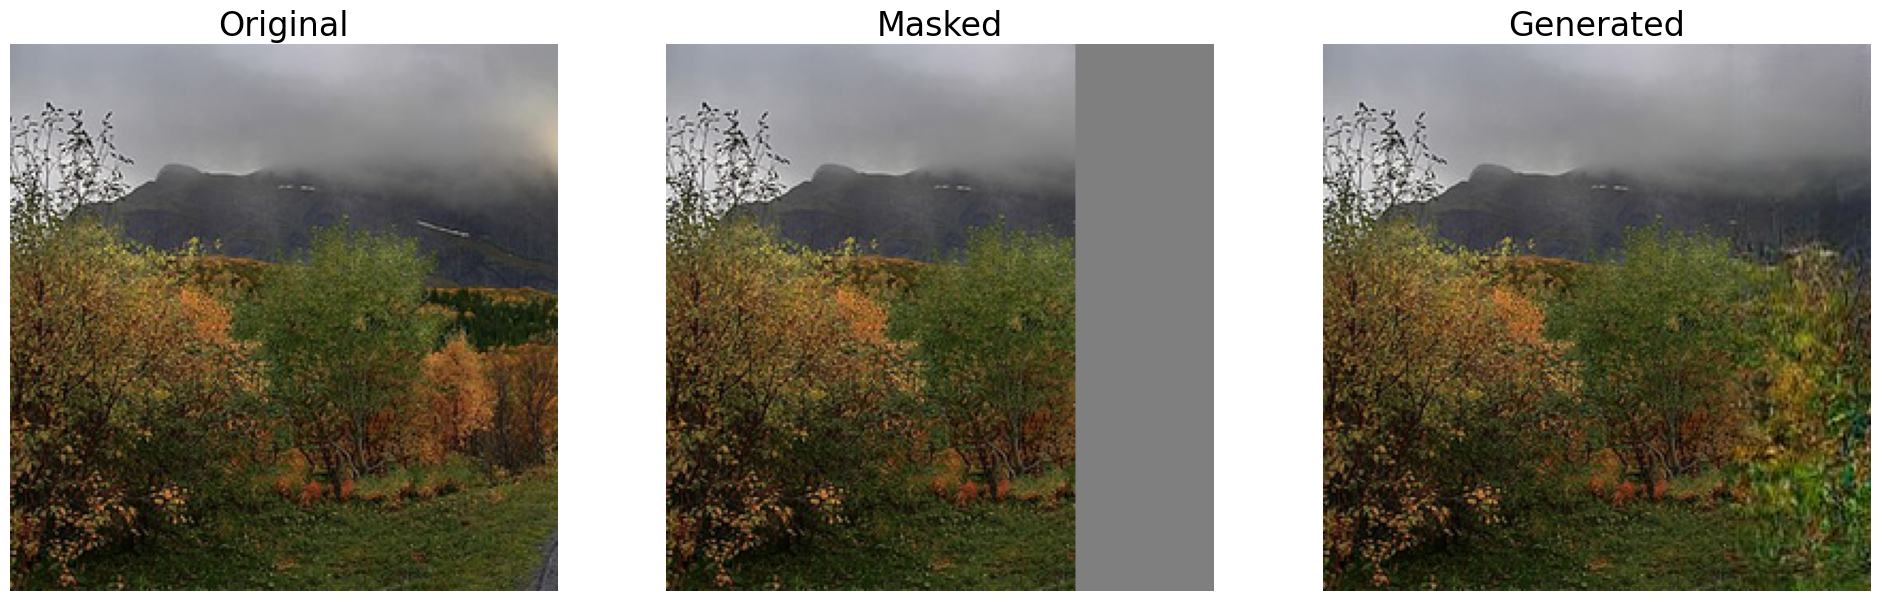

In [8]:
result = model.signatures['default'](tf.constant(input_img))
generated_image =  result['default']
masked_image = result['masked_image']

visualize_output_comparison(input_img, masked_image, generated_image)